<p align="center">
  <img src="images\Hub_title.png" alt="[YOUR_IMAGE_ALT]">
</p>

## ***Business Understanding***

### *Overview*
Tourism is a thriving industry in Kenya, and travelers often face the challenge of choosing the right destinations for their trips. Our project aims to address this problem by creating a recommendation system that assists users in discovering personalized tourist destinations in the country.

### *Problem Statement*

Travelers often struggle to choose the most suitable tourist destinations for their trips. With an overwhelming number of options available, personalized recommendations are crucial. Our project aims to address this challenge by creating a recommendation system that suggests relevant destinations in Kenya based on user preferences and historical interactions.

#### *Stakeholders*
1. **Travelers**: They seek relevant recommendations based on their preferences, interests, and historical interactions.
2. **Tourism Agencies**: These organizations can enhance user experiences by providing tailored suggestions.
3. **Local Businesses**: Recommendations can drive footfall to local attractions, restaurants, and accommodations.

### *Objectives*:

- "Build a collaborative filtering model to recommend destinations."
- "Reduce cold-start problem by incorporating content-based features."
- "Model Recall score ≥ 80%"
- "Model Accuracy ≥ 80%"

### *Proposed Solution and Metrics of Success*
We propose building a hybrid recommendation system that combines collaborative filtering and content-based approaches. Success metrics include accuracy, recall and precision scores.

### *Challenges*

1. **Data Quality and Diversity**:
   - Presence of missing values, outliers, or inaccuracies.
   - Ensuring diverse and representative data across different types of destinations (e.g., cities, beaches, historical sites) is essential.

2. **Cold-Start Problem**:
   - New users with limited interaction history pose a challenge. How do we recommend destinations for them?
   - Balancing collaborative filtering (based on user behavior) with content-based filtering (based on destination features) is critical.

3. **Scalability and Real-Time Recommendations**:
   - As the user base grows, the system must handle increased computational demands.
   - Providing real-time recommendations during user interactions requires efficient algorithms.

4. **User Engagement and Interpretability**:
   - Recommendations should align with user interests to keep them engaged.
   - Ensuring transparency and interpretability of the recommendation process is important.

### *Conclusion*
Our project has significant implications for travelers, tourism agencies, and local businesses. By solving this problem, we contribute to enhancing travel experiences and promoting local economies.


## ***Data Understanding***

### *Data Sources and Relevance*
- The dataset was scraped using the **APIFY Tripadvisor Scraper**.
- It contains information about tourist destinations, including their names, categories, ratings, review counts, images, and other relevant features.
- The data's relevance lies in its ability to help us recommend destinations to travelers based on their preferences and historical interactions.

### *Dataset Overview*
- The dataset consists of **2567 entries** (rows).
- Key columns include:
  - **Name**: The name of the destination.
  - **Category**: The type of destination (e.g., city, beach, historical site).
  - **Rating**: The average user rating (ranging from 1.0 to 5.0).
  - **Number of Reviews**: The count of user reviews.
  - **Image**: URLs to images representing the destinations.
  - **Photo Count**: The number of photos associated with each destination.
  - **Price Range**: Information about the cost level (if available).
  - **Review Tags**: Descriptive tags associated with reviews.
  - **Photos**: Additional photo URLs.
  - **Price Level**: Indication of price range (if available).

### *Justification for Feature Inclusion*
- **Name**, **Category**, and **Rating**: Essential for personalized recommendations.
- **Number of Reviews**: Reflects popularity and user engagement.
- **Image** and **Photo Count**: Enhance user experience.
- **Price Range** and **Price Level**: Useful for budget-conscious travelers.
- **Review Tags**: Provides insights into user preferences.

### *Data Limitations*
- **Missing Values**: Some entries lack ratings, images, or price information.
- **Limited Price Data**: Only 1487 entries have price-related details.
- **Data Quality**: Ensure data quality and handle missing values appropriately.

## ***Data Preparation***

In [70]:
# Importing necessary libraries
import pandas as pd
import json
import glob
import re
import string



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans


from surprise import Dataset, Reader, KNNBasic, SVD, NMF, KNNWithMeans, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection import cross_validate


import warnings
# Ignore future deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style('darkgrid')


class DataCleaning:
    def __init__(self):
        pass

    def read_json_files(self, json_files, expected_columns):
    # Reads multiple JSON files and concatenates them into a single DataFrame
        dfs = []
        for file in json_files:
            with open(file, encoding='utf-8', errors='ignore') as f:
                json_data = json.load(f)
                df = pd.DataFrame([
                        {
                            col: item.get(col, np.nan) for col in expected_columns
                        }
                        for item in json_data                 
                
                    
                ])
                dfs.append(df)
                self.df = pd.concat(dfs, ignore_index=True)
                
        return self.df
    
   
    def drop_columns(self, columns, df):
        # Drops specified columns from the DataFrame
        self.df.drop(columns=columns, inplace=True)
        
    def missing_values_percentage(self, df):
        # Calculates the percentage of missing values in each column
        column_percentages = self.df.isnull().sum() / len(self.df) * 100
        columns_with_missing_values = column_percentages[column_percentages > 0]
        return columns_with_missing_values.sort_values(ascending=False) 
    
    def drop_above_threshold(self, threshold):
        # Drops columns with missing values percentage above the specified threshold
        column_percentages = self.missing_values_percentage(self.df)
        columns_with_missing_values = column_percentages[column_percentages > threshold]
        columns_to_drop = columns_with_missing_values.index.tolist()
        self.df.drop(columns=columns_to_drop, inplace=True)
        
    def split_price_range(self):
        # Splits the priceRange column into LowerPrice and UpperPrice columns
        self.df[['LowerPrice', 'UpperPrice']] = self.df['priceRange'].str.replace('KES', '').str.split(' - ', expand=True)
        self.df['LowerPrice'] = self.df['LowerPrice'].str.replace(',', '').astype(float)
        self.df['UpperPrice'] = self.df['UpperPrice'].str.replace(',', '').astype(float)

    def fill_missing_prices(self):
        # Fills missing values in LowerPrice and UpperPrice columns based on type (ATTRACTION or HOTEL)
        self.df.loc[self.df['type'] == 'ATTRACTION', 'LowerPrice'] = self.df.loc[self.df['type'] == 'ATTRACTION', 'LowerPrice'].fillna(self.df['LowerPrice'].min())
        self.df.loc[self.df['type'] == 'ATTRACTION', 'UpperPrice'] = self.df.loc[self.df['type'] == 'ATTRACTION', 'UpperPrice'].fillna(self.df['UpperPrice'].min())
        self.df.loc[self.df['type'] == 'HOTEL', 'LowerPrice'] = self.df.loc[self.df['type'] == 'HOTEL', 'LowerPrice'].fillna(self.df['LowerPrice'].mean())
        self.df.loc[self.df['type'] == 'HOTEL', 'UpperPrice'] = self.df.loc[self.df['type'] == 'HOTEL', 'UpperPrice'].fillna(self.df['UpperPrice'].mean())


    def clean_ratings(self):
        # Replaces missing values in the rating column with 0
        self.df['rating'].fillna(5, inplace=True)

    def clean_review_tags(self):
        # Cleans up the reviewTags column by extracting the text values
        self.df.loc[:, 'reviewTags'] = self.df['reviewTags'].apply(lambda entries: [{'text': entry['text']} for entry in entries] if isinstance(entries, list) else [])
        self.df.loc[:, 'reviewTags'] = self.df['reviewTags'].apply(lambda tags: [tag['text'] for tag in tags])


    def drop_missing_values(self, columns):
        # Drops rows with missing values in specified columns
        self.df = self.df.dropna(subset=columns)

    def drop_unused_columns(self, columns):
        # Drops unused columns from the DataFrame
        self.df = self.df.drop(columns=columns)

    def drop_rows_with_nan(self):
        # Drops rows with NaN values
        self.df = self.df.dropna()

    def save_to_csv(self, file_path):
        # Saves the DataFrame to a CSV file
        self.df.to_csv(file_path, index=False)





### ***Data Cleaning***

In [2]:
# Importing necessary libraries
import pandas as pd
import json
import glob
import re
import string



import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go


from sklearn.preprocessing import normalize, MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from sklearn.metrics import r2_score
from sklearn.cluster import KMeans


from surprise import Dataset, Reader, KNNBasic, SVD, NMF, KNNWithMeans, SVDpp
from surprise.model_selection import train_test_split
from surprise import accuracy as sup_accuracy
from surprise.prediction_algorithms.matrix_factorization import NMF
from surprise.prediction_algorithms.matrix_factorization import SVD
from surprise.prediction_algorithms.matrix_factorization import SVDpp
from surprise.model_selection import cross_validate


import warnings
# Ignore future deprecation warnings
warnings.filterwarnings("ignore", category=FutureWarning)

sns.set_style('darkgrid')




class DataSourcing:
    def __init__(self):
        self.df = None

    def read_json_files(self, json_files, expected_columns):
    # Reads multiple JSON files and concatenates them into a single DataFrame
        dfs = []
        for file in json_files:
            with open(file, encoding='utf-8', errors='ignore') as f:
                json_data = json.load(f)
                df = pd.DataFrame([
                        {
                            col: item.get(col, np.nan) for col in expected_columns
                        }
                        for item in json_data                 
                
                    
                ])
                dfs.append(df)
                self.df = pd.concat(dfs, ignore_index=True)
                
        return self.df
    
    def dataframe_details(self,df):
        """
        Print details of the dataframe.
        Parameters:
        df (DataFrame): The dataframe to be analyzed.
        Returns:
        None
        """
        print("============================")
        print(f"DATAFRAME SHAPE: {df.shape}")
        print("============================\n\n")
        print("================")
        print(f"DATAFRAME HEAD:")
        print("================")
        print(f"{df.head()}")
        print("========================================================================\n\n")
        print("=======================")
        print(f"DATAFRAME COLUMNS INFO:")
        print("=======================")
        print(f"{df.info()}")
        print("========================================================================\n\n")
        print("==========================")
        print(f"DATAFRAME KEY STATISTICS:")
        print("==========================")
        print(f"{df.describe().transpose()}")
        print("========================================================================\n\n")

    

***DataFrame info***

In [3]:
ds = DataSourcing()

files = [
        "data\kenya.json", "data\Tripadvisor1.json",
        "data\Tripadvisor2.json", "data\Tripadvisor3.json"
        ]
expected_columns = [
        "name", "category", "rating", "numberOfReviews",
        "image", "photoCount", "priceRange", "reviewTags",
        "photos", "priceLevel"
                    ]

data = ds.read_json_files(files, expected_columns)

In [4]:
ds.dataframe_details(data)

DATAFRAME SHAPE: (4544, 10)


DATAFRAME HEAD:
                                      name    category  rating  \
0                         Observation Hill  attraction     4.5   
1             Mount Longonot National Park  attraction     4.5   
2  Karen Blixen Coffee Garden and Cottages  attraction     4.5   
3                           Kiambethu Farm  attraction     5.0   
4                        Fort Jesus Museum  attraction     4.0   

   numberOfReviews                                              image  \
0              782  https://media-cdn.tripadvisor.com/media/photo-...   
1              208  https://media-cdn.tripadvisor.com/media/photo-...   
2              591  https://media-cdn.tripadvisor.com/media/photo-...   
3              226  https://media-cdn.tripadvisor.com/media/photo-...   
4              978  https://media-cdn.tripadvisor.com/media/photo-...   

   photoCount priceRange                                         reviewTags  \
0         423        NaN  [{'text': 'gr

***Check for Duplicates***

In [5]:
# Convert list columns to strings to avoid unhashable type errors
data['reviewTags'] = data['reviewTags'].apply(lambda x: str(x) if isinstance(x, list) else x)
data['photos'] = data['photos'].apply(lambda x: str(x) if isinstance(x, list) else x)

# Check for duplicates
duplicates = data.duplicated()

# Display duplicates
print("Duplicate Rows:")
duplicates.value_counts()

Duplicate Rows:


False    4021
True      523
dtype: int64

*Drop Duplicates*

In [6]:
# Drop the duplicate rows
clean_data = data.drop_duplicates()

# Display the cleaned data
print('Cleaned Data Shape:')
print(clean_data.shape)
print('='*45)
print(clean_data.info())

Cleaned Data Shape:
(4021, 10)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 4021 entries, 0 to 4543
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             4021 non-null   object 
 1   category         4021 non-null   object 
 2   rating           4018 non-null   float64
 3   numberOfReviews  4021 non-null   int64  
 4   image            4018 non-null   object 
 5   photoCount       4021 non-null   int64  
 6   priceRange       2254 non-null   object 
 7   reviewTags       4021 non-null   object 
 8   photos           2567 non-null   object 
 9   priceLevel       2254 non-null   object 
dtypes: float64(1), int64(2), object(7)
memory usage: 345.6+ KB
None


### ***Feature Engineering***

In [7]:
class DataPreprocessing(DataSourcing):
    def __init__(self):
        super().__init__()
        """Data Preprocessing class that inherits from the data sourcing class.
        Contains functions to be used to check certain aspects in the data for cleaning.
        Checks for duplicates, nulls and outliers
        """
      

    def check_duplicates(self, data):
        duplicates = data[data.duplicated()].shape[0]
        print("There are {} duplicates in the data.".format(duplicates))
        
    def check_null_values(self, data):
        null_values = data.isnull().sum()
        print(null_values)
        print("====================================")
        print("List of columns with missing values:")
        print("====================================")
        return null_values[null_values > 0].index.tolist()



In [8]:
# Initialize the data preprocessing class
dp = DataPreprocessing()
data.columns

Index(['name', 'category', 'rating', 'numberOfReviews', 'image', 'photoCount',
       'priceRange', 'reviewTags', 'photos', 'priceLevel'],
      dtype='object')

***1. Extract `reviews` and `texts` from `reviewTags`***

In [9]:
import ast

# Convert the string representations of lists of dictionaries to actual lists of dictionaries
data['reviewTags'] = data['reviewTags'].apply(ast.literal_eval)

# Extract texts and reviews from the reviewTags column
data['texts'] = data['reviewTags'].apply(lambda x: [d['text'] for d in x])
data['reviews'] = data['reviewTags'].apply(lambda x: [d['reviews'] for d in x])

# Display the updated DataFrame
data.head(2)

,name,category,rating,numberOfReviews,image,photoCount,priceRange,reviewTags,photos,priceLevel,texts,reviews
0,Observation Hill,attraction,4.5,782,https://media-cdn.tripadvisor.com/media/photo-...,423,NaN,"[{'text': 'great view', 'reviews': 55}, {'text...",NaN,NaN,"[great view, vantage point, entire park, short...","[55, 17, 16, 15, 11, 8, 89, 141, 137, 81, 98, ..."
1,Mount Longonot National Park,attraction,4.5,208,https://media-cdn.tripadvisor.com/media/photo-...,441,NaN,"[{'text': 'crater rim', 'reviews': 18}, {'text...",NaN,NaN,"[crater rim, day trip, start early, amazing vi...","[18, 14, 10, 8, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, ..."


***2. Decode the `priceLevel` column***

In [10]:
data['priceLevel'].value_counts()

$       823
$$      610
$$$$    516
$$$     305
Name: priceLevel, dtype: int64

*Map the `$` into their corresponding categories*

1. **Luxury**: The most expensive category, offering premium services and facilities.

2. **Premium**: Mid-range in price, providing high-quality services and accommodations.

3. **Standard**: Affordable options with good services and facilities.

4. **Budget**: The most economical choice, offering basic services and accommodations.

In [11]:
# Mapping function
def map_dollar_signs(dollar_signs):
    mapping = {
        "$$$$": "Luxury",
        "$$$": "Premium",
        "$$": "Standard",
        "$": "Budget"
    }
    return mapping.get(dollar_signs, "Unknown")

# Create new column 'priceLevel'
data['priceLevel'] = data['priceLevel'].apply(map_dollar_signs)

# Display the DataFrame
data['priceLevel'].value_counts()

Unknown     2290
Budget       823
Standard     610
Luxury       516
Premium      305
Name: priceLevel, dtype: int64

***3. Create new price columns (`upperPrice` & `lowerPrice`)***

In [12]:
def split_price_range(data, conversion_rate=145.0):
    # Extract unique values from the priceRange column
    unique_price_ranges = data['priceRange'].nunique()

    # Print the number of unique values (optional)
    print(f"Number of unique price ranges: {unique_price_ranges}")

    # Convert USD prices to KES and extract lowerPrice and upperPrice
    def convert_and_extract(x):
        if isinstance(x, str):
            if '$' in x:
                lower_price = float(x.split(' - ')[0].replace('$', '').replace(',', '')) * conversion_rate
                upper_price = float(x.split(' - ')[-1].replace('$', '').replace(',', '')) * conversion_rate
            elif 'KES' in x:
                lower_price = float(x.split(' - ')[0].replace('KES', '').replace(',', ''))
                upper_price = float(x.split(' - ')[-1].replace('KES', '').replace(',', ''))
            return lower_price, upper_price
        return np.nan, np.nan

    data[['lowerPrice', 'upperPrice']] = data['priceRange'].apply(
        lambda x: pd.Series(convert_and_extract(x))
    )

    # Fill missing values with NaN
    data['lowerPrice'] = data['lowerPrice'].fillna(np.nan)
    data['upperPrice'] = data['upperPrice'].fillna(np.nan)

    return data[['lowerPrice', 'upperPrice']].tail()


In [13]:
split_price_range(data)


Number of unique price ranges: 2146


,lowerPrice,upperPrice
4539,NaN,NaN
4540,3374.0,3374.0
4541,NaN,NaN
4542,7008.0,9603.0
4543,2206.0,3763.0


In [14]:
data[['upperPrice', 'lowerPrice']].nunique()

upperPrice    946
lowerPrice    834
dtype: int64

In [15]:
data[['upperPrice', 'lowerPrice']].value_counts().head()

upperPrice  lowerPrice
11679.0     10511.0       7
9084.0      6488.0        5
4542.0      4542.0        4
6488.0      6099.0        4
25954.0     25954.0       4
dtype: int64

***4. Create new column (`weighted_sentiment`) for Sentiment Analysis of Reviews***

##### *STEPS*

    Step 1: Perform Sentiment Analysis

    - We will use TextBlob to calculate the sentiment polarity. (Polarity is a float within the range [-1.0, 1.0], where -1.0 represents a negative sentiment and 1.0 represents a positive sentiment.)

    Step 2: Weight the Sentiment Scores

    Step 3: Aggregate the Weighted Scores

  

We will create an additional column, `weighted_sentiment`, that represents the weighted average sentiment score for each place. This column can be used to make recommendations based on the overall sentiment of reviews.

In [17]:
# !pip install textblob
from textblob import TextBlob

# Perform sentiment analysis and calculate weighted sentiment scores
def calculate_weighted_sentiment(texts, reviews):
    sentiments = [TextBlob(text).sentiment.polarity for text in texts]
    weighted_sentiments = [sentiment * review for sentiment, review in zip(sentiments, reviews)]
    total_reviews = sum(reviews)
    weighted_average_sentiment = sum(weighted_sentiments) / total_reviews if total_reviews > 0 else 0
    return weighted_average_sentiment

# The statistical method below helps in balancing the sentiment score with the number of reviews, preventing
# entities with few reviews from ranking disproportionately high or low.
def bayesian_average(sentiment, num_reviews, C=10, m=0.03):
    """
    sentiment: Weighted sentiment score
    num_reviews: Number of reviews
    C: Weight parameter (the number of reviews we deem sufficient for confidence)
    m: Prior mean sentiment (average sentiment across all entities)
    """
    return (C * m + sentiment * num_reviews) / (C + num_reviews)

data['weighted_sentiment'] = data.apply(lambda row: calculate_weighted_sentiment(row['texts'], row['reviews']), axis=1)

data['adjusted_sentiment'] = data.apply(
    lambda row: bayesian_average(
        row['weighted_sentiment'], 
        row['numberOfReviews'], 
        C=10, 
        m=data['weighted_sentiment'].mean()
    ), 
    axis=1
)


# Display the updated DataFrame
review_data = data[['name','texts','reviews', 'numberOfReviews', 'weighted_sentiment', 'adjusted_sentiment']]

review_data.head()

,name,texts,reviews,numberOfReviews,weighted_sentiment,adjusted_sentiment
0,Observation Hill,"[great view, vantage point, entire park, short...","[55, 17, 16, 15, 11, 8, 89, 141, 137, 81, 98, ...",782,0.039423,0.039170
1,Mount Longonot National Park,"[crater rim, day trip, start early, amazing vi...","[18, 14, 10, 8, 5, 4, 4, 3, 3, 3, 2, 2, 2, 2, ...",208,0.038617,0.037736
2,Karen Blixen Coffee Garden and Cottages,"[movie, africa, giraffes, safari]","[42, 94, 10, 14]",591,0.000000,0.000323
3,Kiambethu Farm,"[indigenous forest, tea plantation, delicious ...","[22, 27, 16, 14, 6, 6, 5, 4, 4, 3, 3, 5, 64, 2...",226,0.050552,0.049232
4,Fort Jesus Museum,"[old town, interesting history, slave trade, t...","[132, 17, 17, 46, 28, 9, 14, 14, 121, 28, 36, ...",978,0.047081,0.046801


In [18]:
data['reviews'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 4544 entries, 0 to 4543
Series name: reviews
Non-Null Count  Dtype 
--------------  ----- 
4544 non-null   object
dtypes: object(1)
memory usage: 35.6+ KB


## ***EDA***

***Visual of the Destinations***

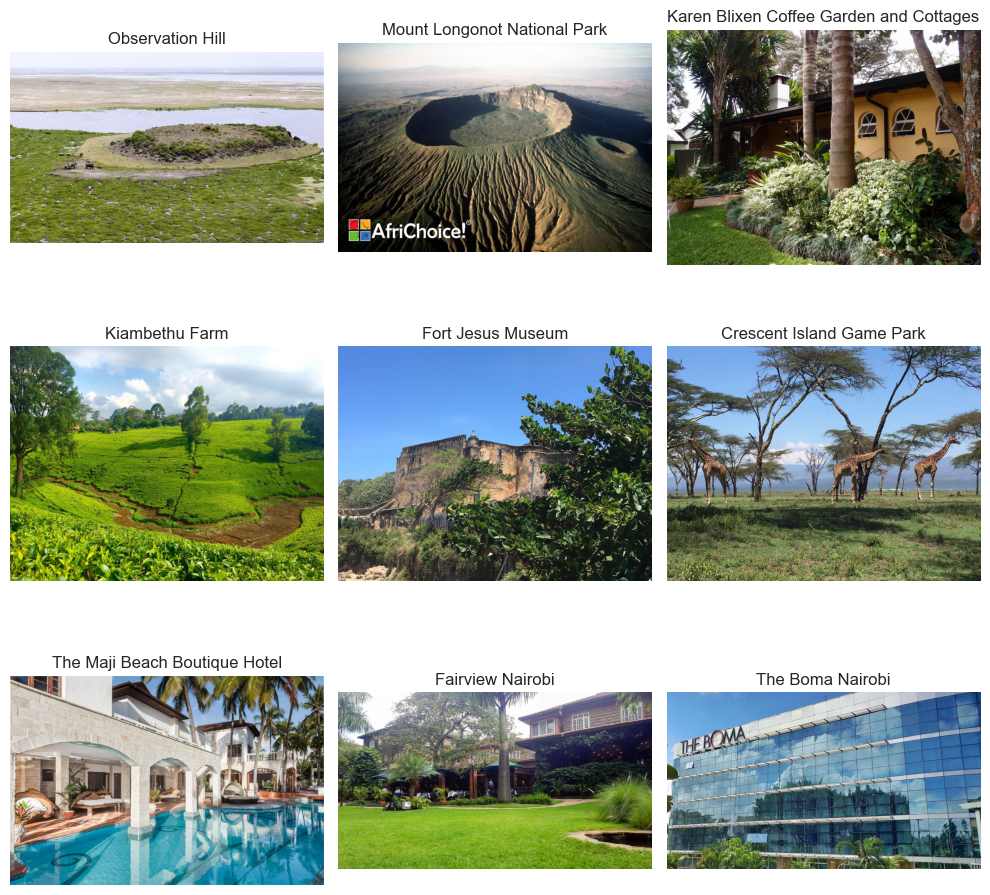

In [ ]:
import requests
from PIL import Image
import io
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Extract image URLs
# Load the first 9 images
image_urls = data['image'].tolist()
images = []

# Download images from URLs
for url in image_urls[0:9]:
    try:
        response = requests.get(url)
        if response.status_code == 200:
            img = Image.open(io.BytesIO(response.content))
            images.append(img)
        else:
            images.append(None)  # Append None if the image couldn't be retrieved
    except Exception as e:
        print(f"Error fetching image from {url}: {e}")
        images.append(None)

# Create a 3x3 grid of images
num_rows, num_cols = 3, 3
image_matrix = [[None for _ in range(num_cols)] for _ in range(num_rows)]

for idx, img in enumerate(images):
    row, col = divmod(idx, num_cols)
    if row < num_rows:
        image_matrix[row][col] = img

# Plot the images with labels
fig, axs = plt.subplots(num_rows, num_cols, figsize=(10, 10))
for i in range(num_rows):
    for j in range(num_cols):
        if image_matrix[i][j] is not None:
            axs[i, j].imshow(image_matrix[i][j])
            axs[i, j].set_title(data.loc[i * num_cols + j, 'name'])
        axs[i, j].axis('off')  # Hide axes

plt.tight_layout()
plt.show()

***Review Bigrams Visual***

A visualization of the most common bigrams in the reviews, weighted by the number of reviews, can be useful for the tour recommendation system to find the most popular words used in the reviews.

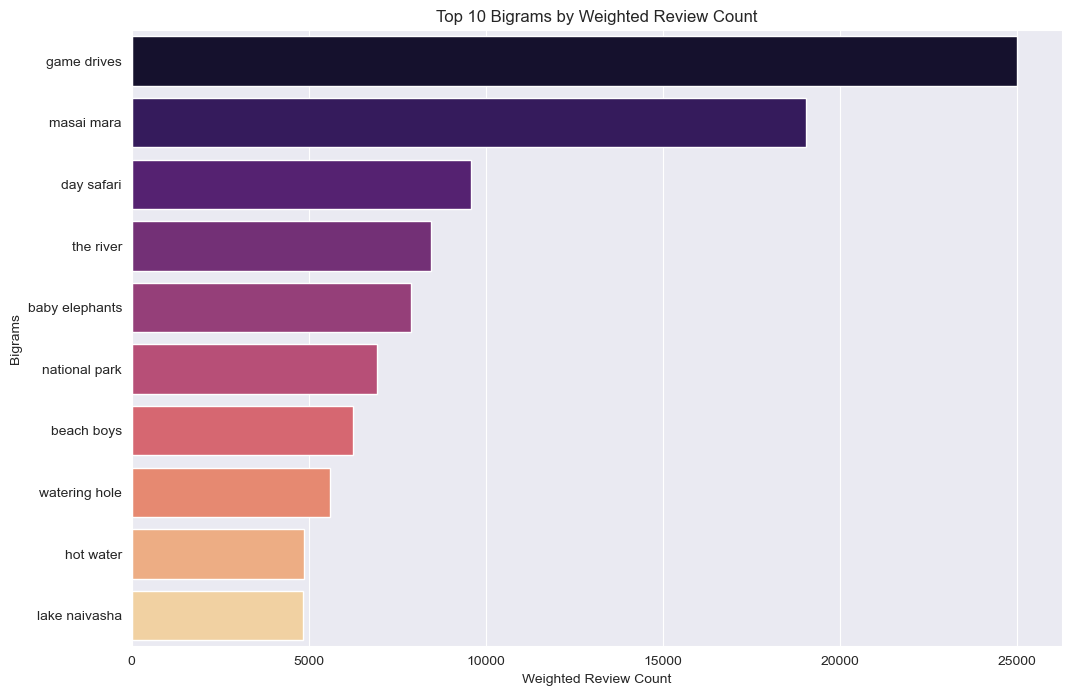

In [19]:
# Tokenize texts into bigrams and count frequencies
import nltk
from nltk.util import bigrams
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Tokenize texts into bigrams and count frequencies
def get_bigrams(texts, reviews):
    bigram_counts = Counter()
    for text, review in zip(texts, reviews):
        tokens = nltk.word_tokenize(text)
        bigrams_list = list(bigrams(tokens))
        for bigram in bigrams_list:
            bigram_counts[bigram] += review
    return bigram_counts

data['bigram_counts'] = data.apply(lambda row: get_bigrams(row['texts'], row['reviews']), axis=1)

# Aggregate bigram counts across all rows
total_bigram_counts = Counter()
for counts in data['bigram_counts']:
    total_bigram_counts.update(counts)

# Get the most common bigrams
most_common_bigrams = total_bigram_counts.most_common(10)
bigram_labels, bigram_values = zip(*most_common_bigrams)

# Convert tuples to strings for labels
bigram_labels = [' '.join(bigram) for bigram in bigram_labels]

# Create DataFrame for plotting
plot_data = pd.DataFrame({'Bigram': bigram_labels, 'Count': bigram_values})

# Visualize the word counts
plt.figure(figsize=(12, 8))
sns.barplot(x='Count', y='Bigram', data=plot_data, palette='magma')
plt.xlabel('Weighted Review Count')
plt.ylabel('Bigrams')
plt.title('Top 10 Bigrams by Weighted Review Count')
plt.show()

*Extract the main bigram that describes the destinations*

In [20]:
# Function to extract the bigram with the highest frequency
def extract_main_bigram(counter):
    if not counter:  # Check if the Counter is empty
        return None
    return max(counter, key=counter.get)

# Apply the function to create the new column
data['main_bigram'] = data['bigram_counts'].apply(extract_main_bigram)

In [21]:
# Limit the bigram counts further
top_n = 50  # Further reduce the number of bigrams
limited_bigram_frequencies = dict(total_bigram_counts.most_common(top_n))
print(f"Number of bigrams: {len(limited_bigram_frequencies)}")
print(f"Memory usage: {sum([len(str(k)) + len(str(v)) for k, v in limited_bigram_frequencies.items()]) / (1024 * 1024):.2f} MB")
import gc

# Clear variables
del total_bigram_counts
gc.collect()


Number of bigrams: 50
Memory usage: 0.00 MB


9884

***Word Cloud Visual***

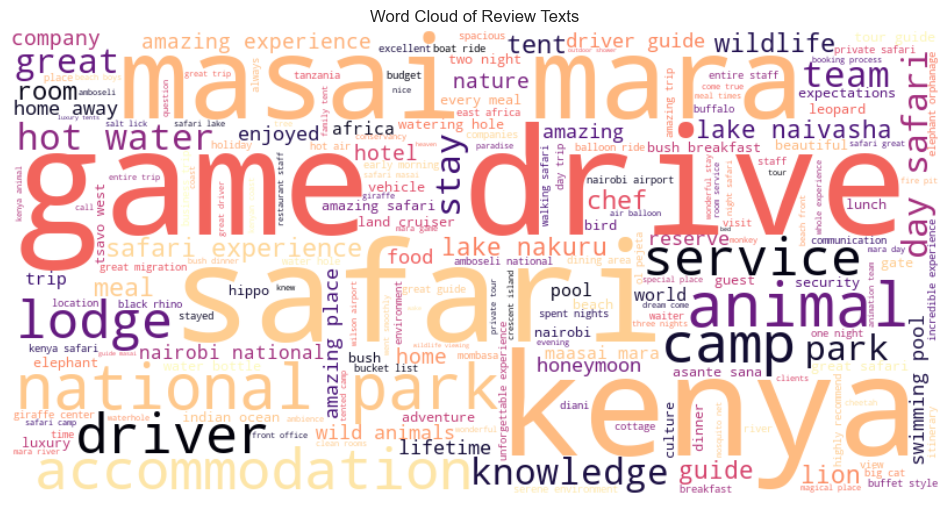

In [22]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Combine all texts into a single string
combined_texts = ' '.join(' '.join(texts) for texts in data['texts'])

# Create a word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='magma').generate(combined_texts)

# Plot the word cloud
plt.figure(figsize=(12, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Review Texts')
plt.show()


### Summary of Key Themes

- **Safari and Wildlife:** The dominant theme is wildlife experiences, highlighted by terms like "safari," "wildlife," "animals," "game drive," and specific animals such as lion, elephant, and giraffe. This suggests a strong emphasis on safari and wildlife activities.

- **Accommodation and Service:** Key terms include "lodge," "camp," "hotel," "service," and "staff," reflecting a focus on guest accommodation and overall service quality.

- **Location:** Geographic terms such as "Masai Mara," "Lake Naivasha," "Kenya," and "Nairobi" underscore the regional focus of the reviews.

- **Positive Sentiment:** Words like "amazing," "great," "beautiful," and "wonderful" point to an overall positive sentiment towards the reviewed experiences.

### Overall Sentiment

- **Positive Sentiment:** Words like "amazing," "great," "beautiful," and "enjoyable" are prevalent across multiple word clouds, suggesting overall positive sentiment towards the locations.
- **Nature and Wildlife:** Words associated with nature, wildlife, and outdoor activities (e.g., "park," "safari," "wildlife," "forest") are prominent, indicating a strong focus on natural experiences.
- **Historical and Cultural Aspects:** Words like “slave,” “trade,” and “colonialism” may point to historical or cultural themes.The presence of “interesting,” “history,” and “culture” suggests educational or informative content.


### ***Univariate Analysis***

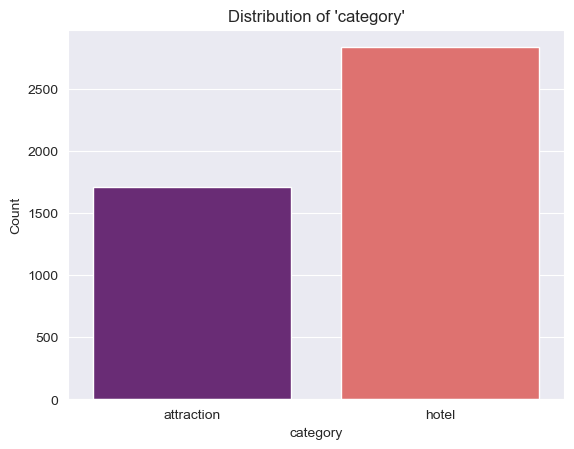

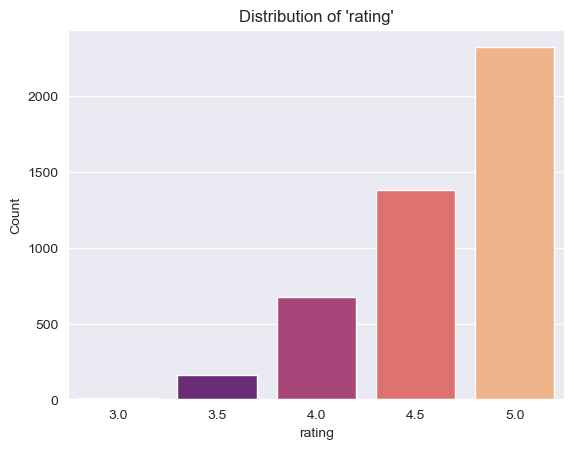

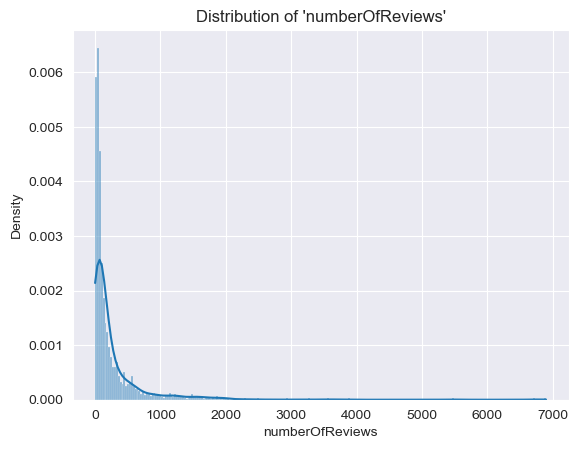

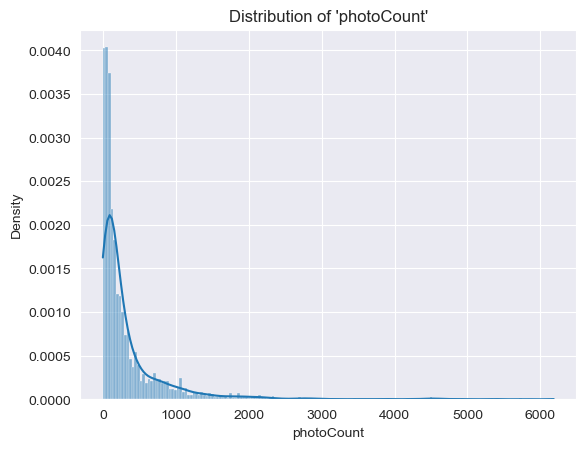

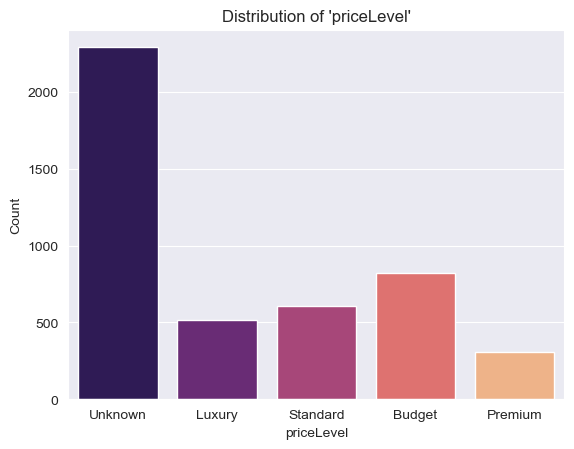

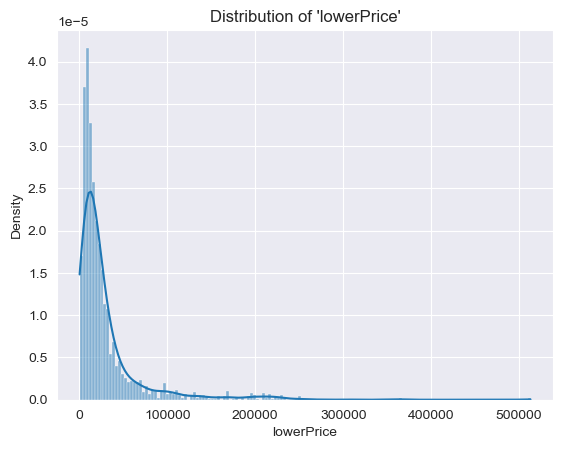

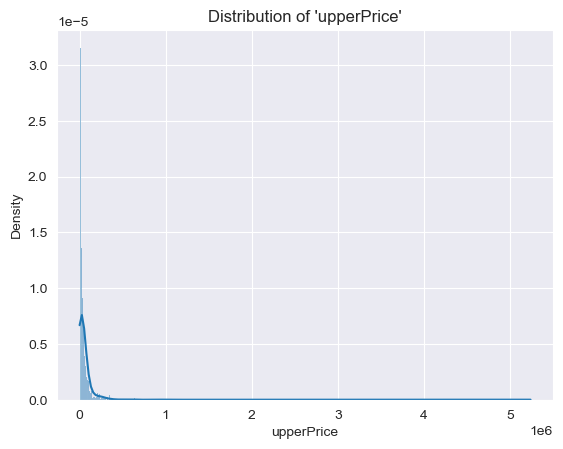

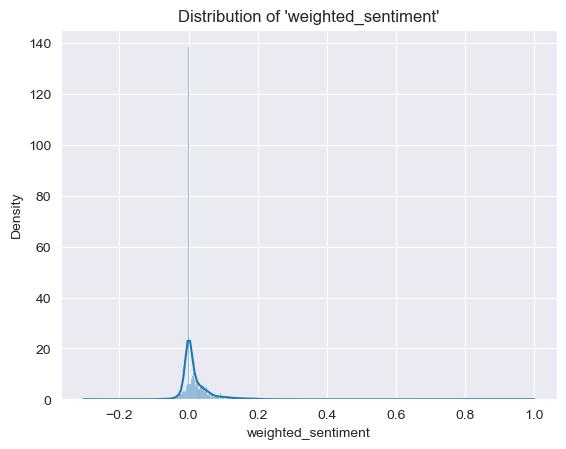

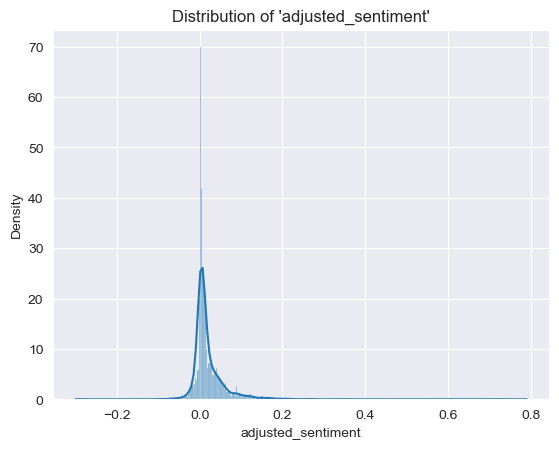

In [25]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_distribution(data, exclude_columns=[]):
    for col in data.columns:
        # Skip the column if it's in the exclude_columns list
        if col in exclude_columns:
            continue
        
        if data[col].dtype == 'object' or data[col].nunique() < 20:
            # If the column is categorical or has less than 20 unique values, use countplot
            custom_palette = 'magma'
            sns.countplot(data=data, x=col, palette=custom_palette)
            plt.title(f"Distribution of '{col}'")
            plt.xlabel(col)
            plt.ylabel('Count')
            plt.xticks()
            plt.show()
        elif pd.api.types.is_numeric_dtype(data[col]):
            # Plot histogram with KDE for numerical columns
            sns.histplot(data[col], kde=True, stat="density")
            plt.title(f"Distribution of '{col}'")
            plt.xlabel(col)
            plt.ylabel('Density')
            plt.show()

# Example usage
exclude = ['name', 'image', 'priceRange', 'reviewTags', 'photos', 'reviews', 'texts', 'bigram_counts', 'main_bigram']
plot_distribution(data, exclude_columns=exclude)


### ***Correlation Analysis***

Label encode the priceLevel so as to perform a correlation analysis.

In [26]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
data['priceLevelencoded'] = label_encoder.fit_transform(data['priceLevel'])


The following columns were dropped due to being object types:
['name', 'category', 'image', 'priceRange', 'reviewTags', 'photos', 'priceLevel', 'texts', 'reviews', 'bigram_counts', 'main_bigram']


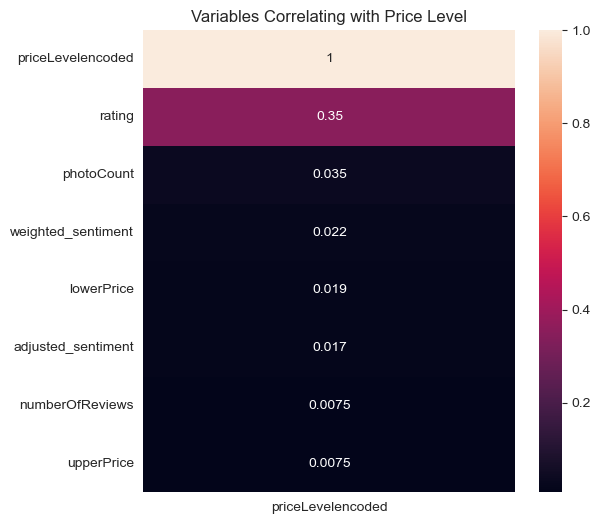

In [27]:
def correlation(df,column=None,rank=None):
    '''
    performs correlation matrix, drops non numeric object types
    variables are dataframe, column, and ranking
    ranking is optional
    column = 'column'
    rank = True for # rank 1,2,3...
    
    '''
    # Redundant check. Makes sure all columns of object type are dropped
    df_object = df.select_dtypes(include='object')
    print(f'The following columns were dropped due to being object types:\n{df_object.columns.tolist()}')
    df = df.drop(df_object,axis=1) 
    df1 = df
    if rank is True:
        try:
            df_corr = df1.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Ranked correlation to {column}')
            return(df_corr.rank(ascending=False).sort_values())
        except:
            df_corr = df1.corr()
            return(df_corr.rank(ascending=False))
    else:    
        try:
            df_corr = df.corr()[column]
            df_corr = df_corr.drop(column)
            print(f'Correlation to {column}')
            return(df_corr.sort_values(ascending=False))
        except:
            df_corr = df1.corr()
            return(df_corr)

# Getting the correlation between variables
df_corr = abs(correlation(data))
fig, ax = plt.subplots(figsize=(6,6))
sns.heatmap(df_corr[['priceLevelencoded']].sort_values(by='priceLevelencoded',ascending=False),annot = True)

ax.set_title('Variables Correlating with Price Level');
# plt.savefig('Group_plots/correlation_plot.png', dpi=100)

In [30]:
# Correlation matrix
correlation_matrix = data[['rating', 'numberOfReviews', 'lowerPrice', 'upperPrice', 'weighted_sentiment', 'adjusted_sentiment']].corr()
correlation_matrix


,rating,numberOfReviews,lowerPrice,upperPrice,weighted_sentiment,adjusted_sentiment
rating,1.000000,-0.094969,0.374819,0.099839,-0.048071,-0.051047
numberOfReviews,-0.094969,1.000000,0.087306,0.026956,0.011743,0.006478
lowerPrice,0.374819,0.087306,1.000000,0.303751,-0.135663,-0.155391
upperPrice,0.099839,0.026956,0.303751,1.000000,-0.007142,-0.018568
weighted_sentiment,-0.048071,0.011743,-0.135663,-0.007142,1.000000,0.986668
adjusted_sentiment,-0.051047,0.006478,-0.155391,-0.018568,0.986668,1.000000


### ***Top 10 Locations***

In [31]:
# Calculate the top 10 names based on average rating
top_10_names = data.groupby('name').agg({'rating': 'mean', 'category': 'first'}).nlargest(10, 'rating')

# Reset index to get 'name' as a column
top_10_names = top_10_names.reset_index()

# Display the table
print("Top 10 Names by Average Rating:")
top_10_names[['name', 'rating', 'category']]

Top 10 Names by Average Rating:


,name,rating,category
0,A Rocha Eco-Lodge & Conservation Centre,5.0,hotel
1,ACROSS WILDERNESS EXPEDITION,5.0,attraction
2,Abdull Safari Kenya,5.0,attraction
3,Absolute Vantage Limited,5.0,attraction
4,Acacia Tree Lodge,5.0,hotel
5,Ace Ecotours,5.0,attraction
6,Ack Guest-House Machakos,5.0,hotel
7,Across The Wild Tours & Safaris,5.0,attraction
8,Adventure 360,5.0,attraction
9,Adventure Wildlife Safaris,5.0,attraction


### ***Bivariate Analysis***

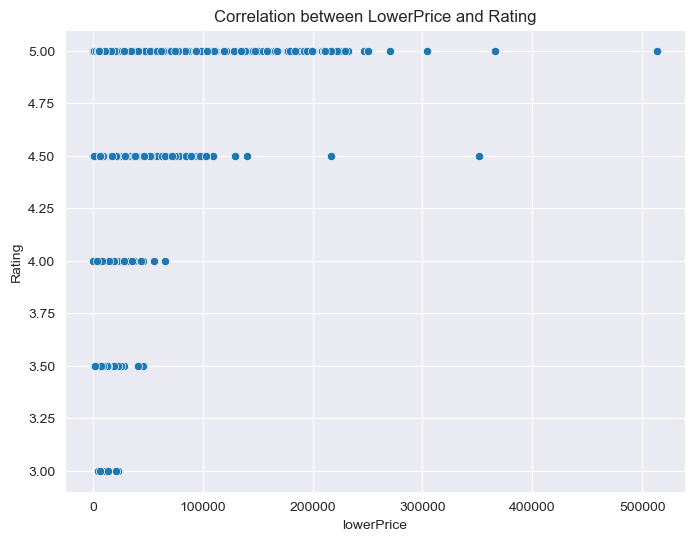

In [33]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['lowerPrice'], y=data['rating'])
plt.title('Correlation between LowerPrice and Rating')
plt.xlabel('lowerPrice')
plt.ylabel('Rating')
plt.show()

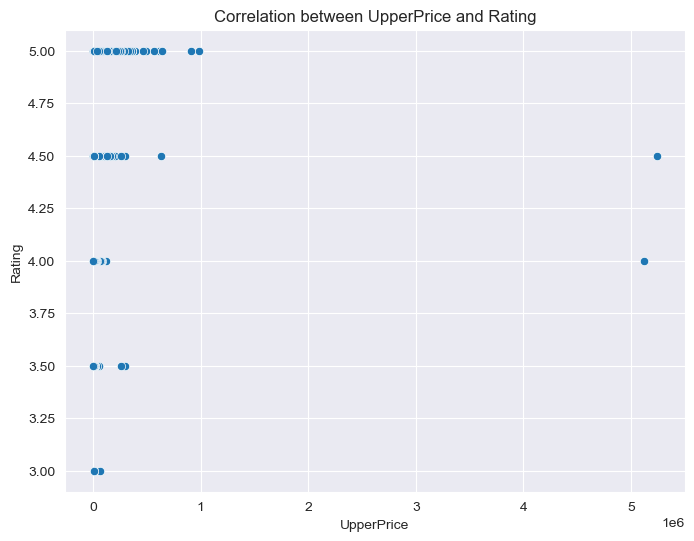

In [34]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['upperPrice'], y=data['rating'])
plt.title('Correlation between UpperPrice and Rating')
plt.xlabel('UpperPrice')
plt.ylabel('Rating')
plt.show()

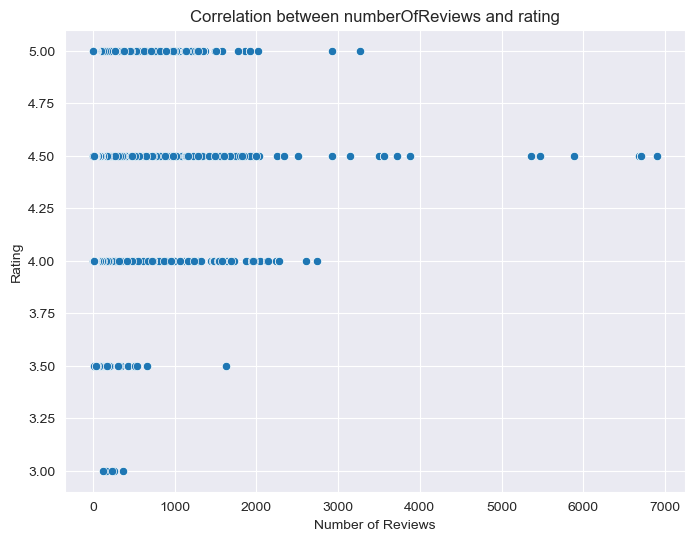

In [35]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['numberOfReviews'], y=data['rating'])
plt.title('Correlation between numberOfReviews and rating')
plt.xlabel('Number of Reviews')
plt.ylabel('Rating')
plt.show()

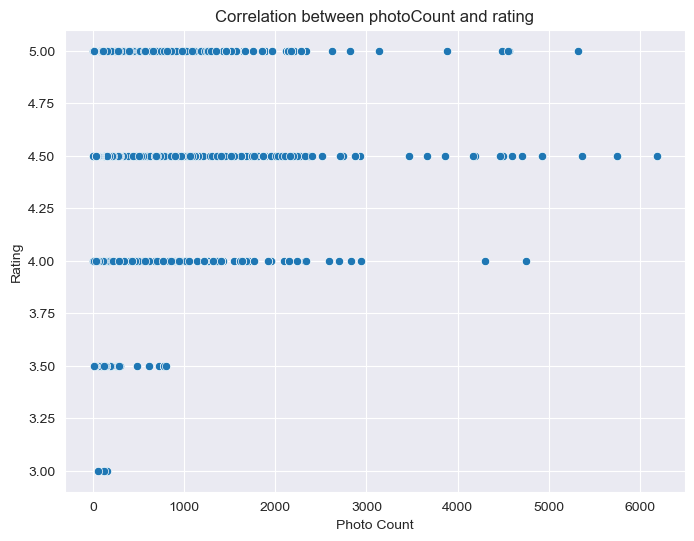

In [36]:

plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['photoCount'], y=data['rating'])
plt.title('Correlation between photoCount and rating')
plt.xlabel('Photo Count')
plt.ylabel('Rating')
plt.show()



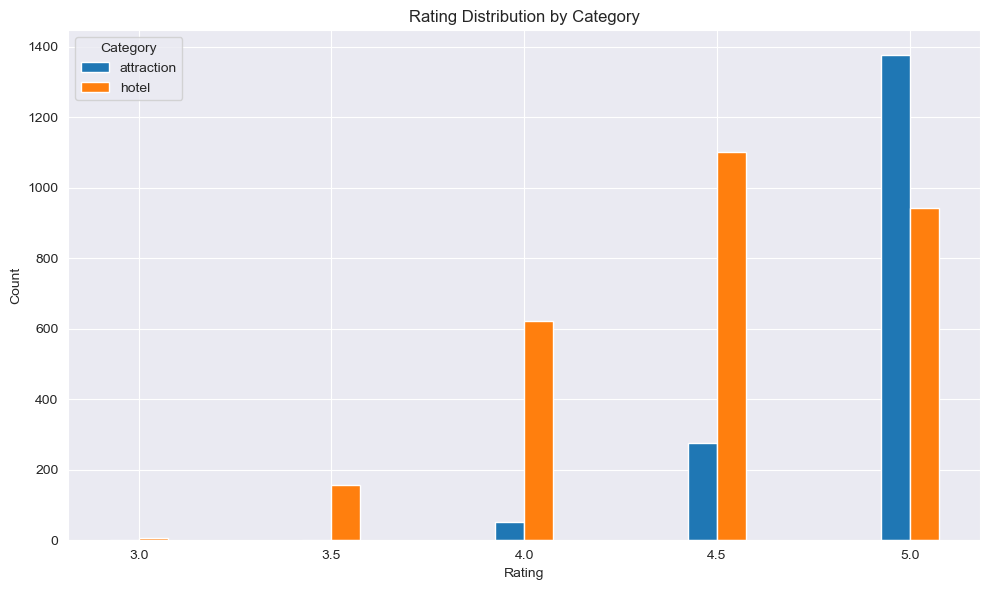

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

grouped_data = data.groupby('category')['rating'].value_counts().unstack().fillna(0)

# Get unique categories and ratings
categories = data['category'].unique()
ratings = grouped_data.columns

# Set the width of each bar
bar_width = 0.15

# Calculate the x position for each group of bars
x = np.arange(len(ratings))

# Create subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot the bars for each category within each rating
for i, category in enumerate(categories):
    ax.bar(x + (i * bar_width), grouped_data.loc[category], width=bar_width, label=category)

# Set the x-axis labels and ticks
ax.set_xticks(x + ((len(categories) - 1) * bar_width) / 2)
ax.set_xticklabels(ratings)
ax.set_xlabel('Rating')
ax.set_ylabel('Count')
ax.set_title('Rating Distribution by Category')
ax.legend(title='Category')

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


- **Higher Ratings for Attractions:** Attractions generally received higher ratings, with a larger number of ratings at 4.5 and 5.0 compared to hotels. This suggests that customers are more satisfied with attractions.

- **Bimodal Distribution for Hotels:** Hotel ratings show a bimodal distribution with peaks around 3.5 and 4.5. This indicates a split in customer experiences, with some customers being highly satisfied while others are less so.


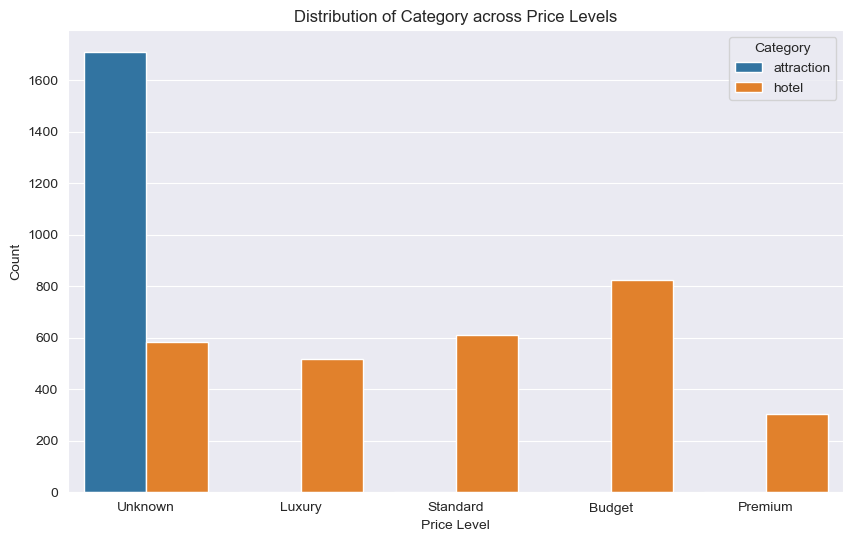

In [38]:

plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='priceLevel', hue='category')
plt.title('Distribution of Category across Price Levels')
plt.xlabel('Price Level')
plt.ylabel('Count')
plt.legend(title='Category')
plt.show()

In [39]:
combined_table = data.groupby(['category', 'priceLevel']).agg(
    avg_rating=('rating', 'mean'),
    total_reviews=('numberOfReviews', 'sum'),
    avg_photo_count=('photoCount', 'mean')
).reset_index()

combined_table

,category,priceLevel,avg_rating,total_reviews,avg_photo_count
0,attraction,Unknown,4.888108,443939,366.724824
1,hotel,Budget,4.331509,94733,105.532199
2,hotel,Luxury,4.780039,217924,613.883721
3,hotel,Premium,4.470492,172344,690.380328
4,hotel,Standard,4.387521,251184,389.472131
5,hotel,Unknown,4.611684,62668,174.139175


### Summary
The attraction category lacks price data and this presents a challenge. We will handle the issue by creating separate models for each category.

We will build two different recommendation models: one for attractions and one for hotels. Since attractions don’t have price data, we will exclude priceLevel from the model for attractions and focus on other features like rating and reviews.

This approach will allow tailoring the recommendation model specifically to the available data for each category.

In [74]:
# data.to_csv('C:/Users/Hp/Documents/DATA_SCIENCE/MORINGA/PHASE_5-Final_Project/SafariHub/data.csv', index=False)

In [ ]:
# Filter the rows where the 'category' is 'attraction'
attraction_data = data[data['category'] == 'attraction'][[
    'name', 'category', 'rating', 'numberOfReviews', 'photoCount', 'texts',
    'reviews', 'weighted_sentiment', 'adjusted_sentiment', 'bigram_counts'
]]

# Filter the rows where the 'category' is 'hotel'
hotel_data = data[data['category'] == 'hotel'][[
    'name', 'category', 'rating', 'numberOfReviews', 'photoCount',
       'priceRange', 'reviewTags', 'priceLevel', 'texts', 'reviews',
       'lowerPrice', 'upperPrice', 'weighted_sentiment', 'adjusted_sentiment',
       'bigram_counts', 'priceLevelencoded'
]]

In [56]:
attraction_data.shape

(1708, 10)

In [57]:
hotel_data.shape

(2836, 16)

In [64]:
data1 = attraction_data.dropna()
data1.shape

(1707, 10)

In [63]:
data2 = hotel_data.dropna()
data2.shape

(2252, 16)

# ***Modeling***

In [67]:
# from sklearn.preprocessing import StandardScaler
# # from sklearn.model_selection import train_test_split
# from sklearn.neighbors import NearestNeighbors

# # 1. Preprocessing
# scaler = StandardScaler()
# hotel_features = data2[['rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment', 'lowerPrice', 'upperPrice']]
# hotel_features_scaled = scaler.fit_transform(hotel_features)

# # attraction_features = attraction_data[['rating', 'numberOfReviews', 'photoCount', 'adjusted_sentiment']]
# # attraction_features_scaled = scaler.transform(attraction_features)

# # 2. Model Selection
# # Example: Using KNN for content-based recommendation
# model = NearestNeighbors(n_neighbors=5, metric='cosine')
# model.fit(hotel_features_scaled)

# # 3. Making Predictions
# # For a given input (e.g., a user query or existing hotel), find similar items
# query_index = 0  # example index
# distances, indices = model.kneighbors([hotel_features_scaled[query_index]])

# # Get recommended hotel indices and their features
# recommended_hotels = hotel_data.iloc[indices[0]]

# print(recommended_hotels[['name', 'rating', 'priceRange']])

# # You can repeat similar steps for attractions


                               name  rating               priceRange
6     The Maji Beach Boutique Hotel     5.0  KES 34,459 - KES 63,150
1008           Ngutuni Safari Lodge     4.5                     None
1469              Severin Sea Lodge     4.0              $163 - $246
889                  Mara Bush Camp     5.0               KES 27,567
1283          Severin Kitani Bandas     4.5                     None


In [ ]:
# train, test = train_test_split(data2, test_size = .2)

In [ ]:
# svd = SVD()
# svd.fit(train)
# predictions = svd.test(test)

In [ ]:
# accuracy.rmse(predictions)